# Setup



## Get files / dependencies

In [14]:
%tensorflow_version 1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [15]:
!git clone https://github.com/google-research/proteinfer 

%cd proteinfer

!pip3 install -qr  requirements.txt

import pandas as pd
import tensorflow
import inference
import parenthood_lib
import baseline_utils,subprocess
import shlex
import tqdm 
import sklearn
import numpy as np
import utils
import colab_evaluation
import plotly.express as px

from plotnine import ggplot, geom_point, geom_ribbon, geom_line, aes, stat_smooth, facet_wrap, xlim,coord_cartesian,theme_bw,labs,ggsave


Cloning into 'proteinfer'...
remote: Enumerating objects: 480, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 480 (delta 94), reused 49 (delta 20), pack-reused 277
Receiving objects: 100% (480/480), 9.83 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (233/233), done.
/content/proteinfer/proteinfer
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires numpy>=1.18.5, but you have numpy 1.16.2 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.4 which is incompatible.


In [16]:
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/models/zipped_models/noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz
!tar xzf noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/parenthood.json.gz
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_EC/eval_test.fasta

## Load vocabulary and parenthood information

In [17]:
vocab = inference.Inferrer(
    'noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140'
).get_variable('label_vocab:0').astype(str)
label_normalizer = parenthood_lib.get_applicable_label_dict(
    'parenthood.json.gz')

## Define a helper function to download inference results

In [18]:
def download_inference_results(run_name):
    file_shard_names = [
        '-{:05d}-of-00064.predictions.gz'.format(i) for i in range(64)
    ]
    subprocess.check_output(
        shlex.split(f'mkdir -p ./inference_results/{run_name}/'))

    for shard_name in tqdm.tqdm(file_shard_names,
                                position=0,
                                desc="Downloading"):
        subprocess.check_output(
            shlex.split(
                f'wget https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/swissprot_inference_results/{run_name}/{shard_name} -O ./inference_results/{run_name}/{shard_name}'
            ))
    return


## Downloading predictions and getting them ready for analysis

In [19]:
min_decision_threshold = 1e-10
download_inference_results(f"ec_random_test")
predictions_df = colab_evaluation.get_normalized_inference_results(
    "inference_results/ec_random_test",
    vocab,
    label_normalizer,
    min_decision_threshold=min_decision_threshold)


100%|██████████| 64/64 [01:41<00:00,  1.54s/it]


In [20]:
test_ground_truth = baseline_utils.load_ground_truth('eval_test.fasta')
ground_truth_df = colab_evaluation.make_tidy_df_from_ground_truth(
    test_ground_truth)
del test_ground_truth

108578it [00:01, 107862.80it/s]
100%|██████████| 54289/54289 [00:00<00:00, 66162.01it/s]


# Analysis

Now we can get some statistics about our predictions. Let's start with a simple calculation of precision, recall and F1 for the whole dataset at a threshold of 0.5. 

What happens in different EC classes - is there differential performance?

In [21]:
def get_first_level_of_ec_hierarchy(ec):
    ec_group_names = {
        "EC:1": "Oxidoreductases",
        "EC:2": "Transferases",
        "EC:3": "Hydrolases",
        "EC:4": "Lyases",
        "EC:5": "Isomerases",
        "EC:6": "Ligases",
        "EC:7": "Translocases"
    }
    return ec_group_names[ec.split(".")[0]]


top_level_ec_grouping = {x: get_first_level_of_ec_hierarchy(x) for x in vocab}

colab_evaluation.apply_threshold_and_return_stats(
    predictions_df, ground_truth_df, grouping=top_level_ec_grouping)

,group,tp,fp,fn,precision,recall,f1,count,proportion,proportion_text,threshold
0,Hydrolases,21541,460,1063,0.979092,0.952973,0.965856,22604,0.219048,21.9%,0.5
1,Isomerases,5631,49,157,0.991373,0.972875,0.982037,5788,0.056090,5.61%,0.5
2,Ligases,11198,25,139,0.997772,0.987739,0.992730,11337,0.109863,10.99%,0.5
3,Lyases,9294,80,364,0.991466,0.962311,0.976671,9658,0.093593,9.36%,0.5
4,Oxidoreductases,11641,271,622,0.977250,0.949278,0.963061,12263,0.118837,11.88%,0.5
5,Transferases,37143,494,926,0.986875,0.975676,0.981243,38069,0.368914,36.89%,0.5
6,Translocases,3402,26,71,0.992415,0.979557,0.985944,3473,0.033656,3.37%,0.5


In [22]:
ec_pr_curves = colab_evaluation.get_pr_curve_df(
    predictions_df, ground_truth_df, grouping=top_level_ec_grouping)

fig = px.line(ec_pr_curves, 
    x="recall", y="precision", color="group")
fig.update_layout(template="plotly_white", title="Performance by EC class")


fig.update_yaxes(range=(0.92, 1))

100%|██████████| 7/7 [00:00<00:00, 36.80it/s]


And what about at different levels of the EC hierarchy?

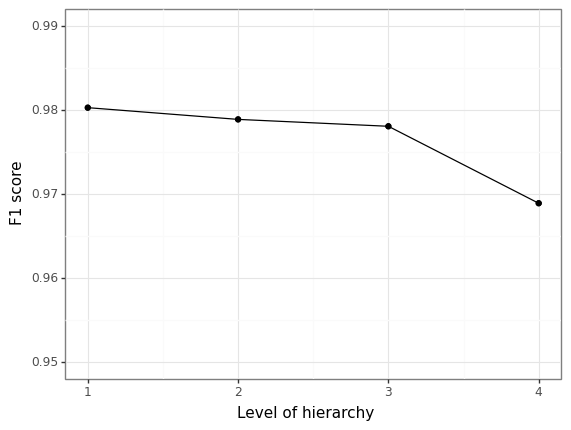

<ggplot: (8790441904393)>

In [23]:
def get_level_of_hierarchy(ec):
    num_of_dashes = ec.count("-")
    level_of_hierarchy = 4 - num_of_dashes
    return level_of_hierarchy


level_of_hierachy_grouping = {x: get_level_of_hierarchy(x) for x in vocab}

level_data = colab_evaluation.apply_threshold_and_return_stats(
    predictions_df, ground_truth_df, grouping=level_of_hierachy_grouping)
ggplot(level_data, aes(x="group", y="f1")) + geom_point() + geom_point(
) + geom_line() + theme_bw() + labs(
    x="Level of hierarchy", y="F1 score") + coord_cartesian(ylim=[0.95, 0.99])

Now let's try varying the threshold to generate a precision-recall curve.

In [24]:
cnn_pr_data = colab_evaluation.get_pr_curve_df(predictions_df, ground_truth_df)


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


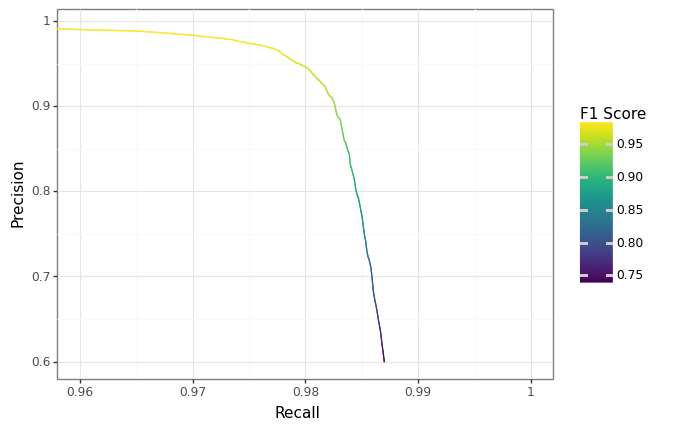

<ggplot: (8790441953617)>

In [25]:
ggplot(cnn_pr_data.drop(index=0),
       aes(x="recall", y="precision",
           color="f1")) + geom_line() + geom_line() + coord_cartesian(
               xlim=(0.96, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="F1 Score")


What decision threshold maximises F1 score?

In [26]:
cnn_pr_data.sort_values('f1', ascending=False)[:3]


,group,precision,recall,threshold,f1
177,all,0.986568,0.967323,0.625205,0.976851
176,all,0.986385,0.967430,0.590015,0.976815
178,all,0.986577,0.967216,0.639263,0.976801


Now let's have a look at PR curves for each different top level group.

# Load CNN ensemble predictions

In [27]:
min_decision_threshold = 1e-10
download_inference_results(f"ec_random_test_ens")
ens_predictions_df = colab_evaluation.get_normalized_inference_results(
    "inference_results/ec_random_test_ens",
    vocab,
    label_normalizer,
    min_decision_threshold=min_decision_threshold)


100%|██████████| 64/64 [01:50<00:00,  1.69s/it]


In [28]:
ens_cnn_pr_data = colab_evaluation.get_pr_curve_df(ens_predictions_df,
                                                   ground_truth_df)


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


In [29]:
ens_cnn_pr_data.sort_values('f1', ascending=False)[0:3]


,group,precision,recall,threshold,f1
170,all,0.985678,0.975735,0.253779,0.980681
171,all,0.985783,0.975628,0.257399,0.980679
176,all,0.986421,0.974998,0.274864,0.980676


In [30]:
cnn_pr_data['method'] = "CNN"
ens_cnn_pr_data['method'] = "CNN Ensemble"

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



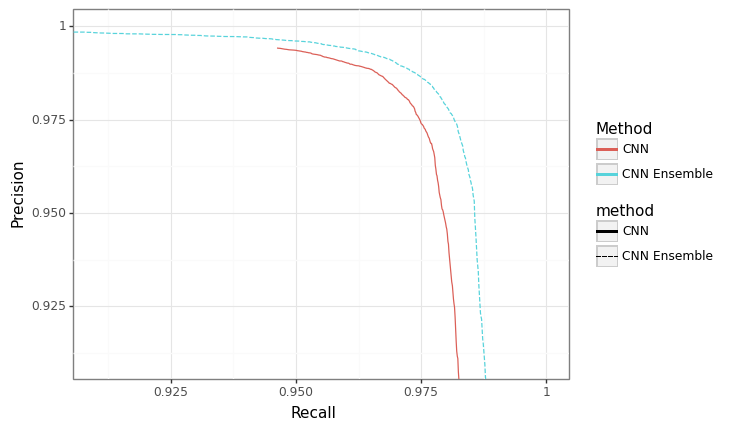

<ggplot: (8790442408473)>

In [31]:
method_comparison = pd.concat([cnn_pr_data, ens_cnn_pr_data],
                              ignore_index=True)
ggplot(method_comparison,
       aes(x="recall", y="precision", color="method",
           linetype="method")) + geom_line() + coord_cartesian(
               xlim=(0.91, 1), ylim=(0.91, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method")


# Blast comparison

Let's do the same sort of analysis for a BLAST baseline.

In [32]:
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/blast_output/random/blast_out_test.tsv
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_EC/eval_test.fasta
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_EC/train.fasta
train_ground_truth = colab_evaluation.make_tidy_df_from_ground_truth(baseline_utils.load_ground_truth('train.fasta')).rename(columns={"up_id":"train_seq_id"}).drop(columns=["gt"])

877044it [00:07, 123593.34it/s]
100%|██████████| 438522/438522 [00:06<00:00, 66985.53it/s]


In [33]:
blast_out = colab_evaluation.read_blast_table("blast_out_test.tsv")
blast_df = blast_out.merge(train_ground_truth,
                           left_on="target",
                           right_on="train_seq_id")
blast_df.rename(columns={'bit_score': 'value', "query": "up_id"}, inplace=True)


In [34]:
min_decision_threshold = 0
blast_pr_data = colab_evaluation.get_pr_curve_df(blast_df, ground_truth_df)
blast_pr_data['method'] = 'BLAST'

100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



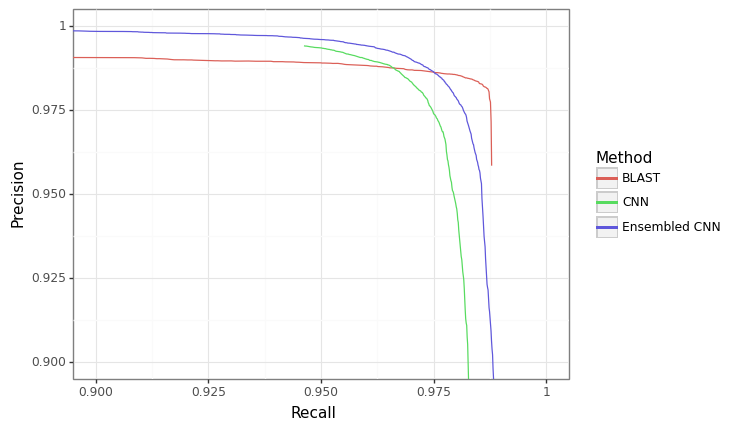

<ggplot: (8790441922421)>

In [35]:
cnn_pr_data['method'] = 'CNN'
ens_cnn_pr_data['method'] = 'Ensembled CNN'
method_comparison = pd.concat([
    cnn_pr_data.drop(index=0),
    ens_cnn_pr_data.drop(index=0),
    blast_pr_data.drop(index=0)
],
                              ignore_index=True)
ggplot(method_comparison,
       aes(x="recall", y="precision",
           color="method")) + geom_line() + coord_cartesian(
               xlim=(0.90, 1), ylim=(0.90, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method")


In [36]:
method_comparison.groupby("method")[['f1']].agg(max)

,f1
method,
BLAST,0.984229
CNN,0.976851
Ensembled CNN,0.980681


In [37]:
method_comparison.sort_values('f1',
                              ascending=False).drop_duplicates(['method'])


,group,precision,recall,threshold,f1,method
1169,all,0.982717,0.985745,60.500000,0.984229,BLAST
508,all,0.985678,0.975735,0.253779,0.980681,Ensembled CNN
176,all,0.986568,0.967323,0.625205,0.976851,CNN


Let's investigate what's going on at the left hand side of the graph where the CNN and ensemble achieve greater precision than BLAST.

In [38]:
def get_x_where_y_is_closest_to_z(df, x, y, z):
    return df.iloc[(df[y] - z).abs().argsort()[:1]][x]


cnn_threshold = float(
    get_x_where_y_is_closest_to_z(cnn_pr_data,
                                  x="threshold",
                                  y="recall",
                                  z=0.96))
blast_threshold = float(
    get_x_where_y_is_closest_to_z(blast_pr_data,
                                  x="threshold",
                                  y="recall",
                                  z=0.96))

cnn_results = colab_evaluation.assign_tp_fp_fn(ens_predictions_df,
                                               ground_truth_df, cnn_threshold)

blast_results = colab_evaluation.assign_tp_fp_fn(blast_df, ground_truth_df,
                                                 blast_threshold)

merged = cnn_results.merge(blast_results,
                           how="outer",
                           suffixes=("_ens_cnn", "_blast"),
                           left_on=["label", "up_id", "gt"],
                           right_on=["label", "up_id", "gt"])


In [39]:
blast_info = blast_out[['up_id', 'target', 'pc_identity']]


Let's list some of the BLAST false-positives in case we want to investigate what's going on.

In [40]:
merged.query("fp_blast==True and fp_ens_cnn==False").head()

,up_id,label,value_ens_cnn,gt,tp_ens_cnn,fp_ens_cnn,fn_ens_cnn,target,pc_identity,alignment_length,value_blast,train_seq_id,tp_blast,fp_blast,fn_blast
1489,Q9VXP4,EC:3.-.-.-,0.831271,False,False,False,False,O35264,48.416,114,229,O35264,False,True,False
1490,Q9VXP4,EC:3.1.-.-,0.831271,False,False,False,False,O35264,48.416,114,229,O35264,False,True,False
1491,Q9VXP4,EC:3.1.1.-,0.089787,False,False,False,False,O35264,48.416,114,229,O35264,False,True,False
1492,Q9VXP4,EC:3.1.1.47,0.089787,False,False,False,False,O35264,48.416,114,229,O35264,False,True,False
2004,Q9SP62,EC:1.14.19.6,0.0393828,False,False,False,False,Q8GZC3,63.859,131,514,Q8GZC3,False,True,False


# An ensemble of BLAST and ensembled-CNNs

We've seen that the CNN-ensemble and BLAST have different strengths - at lower recalls the CNN appears to have greater precision than BLAST at lower recalls, but BLAST has better recall at lower precisions. Can we combine these approaches to get a predictor with the best of both worlds?

In [41]:
blast_and_cnn_ensemble = ens_predictions_df.merge(blast_df,
                                                  how="outer",
                                                  suffixes=("_ens_cnn",
                                                            "_blast"),
                                                  left_on=["label", "up_id"],
                                                  right_on=["label", "up_id"])


In [42]:
blast_and_cnn_ensemble = blast_and_cnn_ensemble.fillna(False)


We will create a simple ensemble where the value of the predictor is simply the multiple of the probability assigned by the ensemble of neural networks and the bit-score linking this sequence to to an example with this label by BLAST.

In [43]:
blast_and_cnn_ensemble['value'] = blast_and_cnn_ensemble[
    'value_ens_cnn'] * blast_and_cnn_ensemble['value_blast']


In [44]:
blast_and_cnn_ensemble_pr = colab_evaluation.get_pr_curve_df(
    blast_and_cnn_ensemble, ground_truth_df)

100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


In [45]:
blast_and_cnn_ensemble_pr.f1.max()

0.9863972357083497

In [46]:
blast_and_cnn_ensemble_pr['method'] = 'Ensemble of BLAST  with  Ensembled-CNN'


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



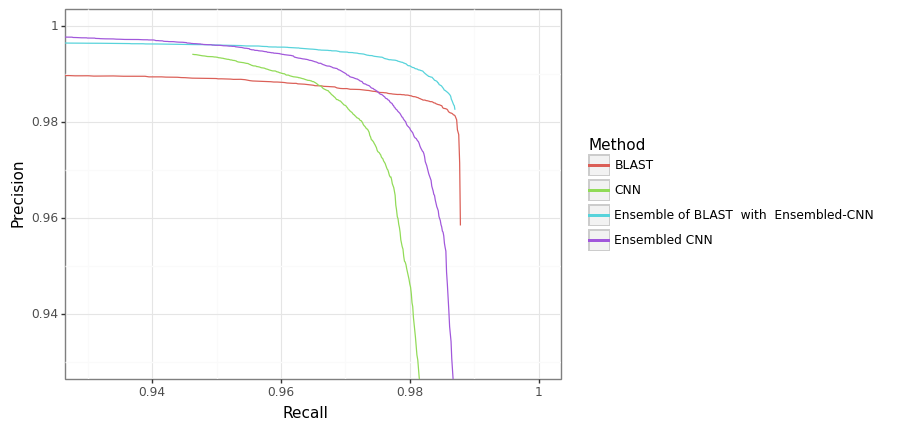

<ggplot: (8790414928861)>

In [47]:
cnn_pr_data['method'] = 'CNN'
ens_cnn_pr_data['method'] = 'Ensembled CNN'
method_comparison = pd.concat([
    cnn_pr_data.drop(index=0),
    ens_cnn_pr_data.drop(index=0),
    blast_pr_data.drop(index=0),
    blast_and_cnn_ensemble_pr.drop(index=0)
],
                              ignore_index=True)
ggplot(method_comparison,
       aes(x="recall", y="precision",
           color="method")) + geom_line() + coord_cartesian(
               xlim=(0.93, 1), ylim=(0.93, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method") 


In [48]:
method_comparison = method_comparison.query("recall!=1.0")
fig = px.line(method_comparison, x="recall", y="precision", color="method")
fig.update_layout(template="plotly_white", title="Precision-recall by method")
fig.update_xaxes(range=(0.95, 1))
fig.update_yaxes(range=(0.95, 1))
fig.show()
json = fig.to_json(pretty=True)
with open("method.json", "w") as f:
    f.write(json)


In [49]:
method_comparison.groupby("method")[['f1']].agg(max)

,f1
method,
BLAST,0.984229
CNN,0.976851
Ensemble of BLAST with Ensembled-CNN,0.986397
Ensembled CNN,0.980681


# Bootstrapping

## Defining functions

In [50]:
import collections


def get_bootstrapped_pr_curves(predictions_df,
                               ground_truth_df,
                               grouping=None,
                               n=100,
                               method_label=None,
                               sample_with_replacement=True):

    joined = predictions_df[predictions_df.value > 1e-10].merge(
        ground_truth_df, on=['up_id', 'label'], how='outer')
    unique_up_ids = joined['up_id'].unique()

    pr_samples = []
    for _ in tqdm.tqdm(range(n)):
        sampled_up_ids = np.random.choice(unique_up_ids, len(unique_up_ids),
                                          sample_with_replacement)

        count_by_sample = collections.Counter(sampled_up_ids)
        count_by_sample_ordered = [count_by_sample[x] for x in joined.up_id]
        joined_sampled = pd.DataFrame(np.repeat(joined.values,
                                                count_by_sample_ordered,
                                                axis=0),
                                      columns=joined.columns)
        unique_suffixes_counter = collections.defaultdict(lambda: 0)
        unique_suffixes = []
        for row in joined_sampled.values:
            lookup_key = (row[0], row[1])
            unique_suffixes.append(unique_suffixes_counter[lookup_key])
            unique_suffixes_counter[lookup_key] += 1

        joined_sampled['up_id'] = [
            f'{x}-{y}' for x, y in zip(joined_sampled.up_id, unique_suffixes)
        ]

        pred = joined_sampled[joined_sampled['value'].notna()][[
            'up_id', 'label', 'value'
        ]]
        gt = joined_sampled[joined_sampled['gt'].notna()][[
            'up_id', 'label', 'gt'
        ]]

        pr_curves = colab_evaluation.get_pr_curve_df(pred,
                                                     gt,
                                                     grouping=grouping)
        pr_curves.loc[pr_curves['threshold'] == 0.0, 'precision'] = 0
        pr_curves.loc[pr_curves['threshold'] == 0.0, 'f1'] = 0
        pr_curves['type'] = method_label
        pr_samples.append(pr_curves)
    return pr_samples


## Perform calculations

In [51]:
n = 100
non_ensembled_prs = get_bootstrapped_pr_curves(predictions_df,
                                               ground_truth_df,
                                               n=n,
                                               method_label="Single CNN")

ensembled_prs = get_bootstrapped_pr_curves(ens_predictions_df,
                                           ground_truth_df,
                                           n=n,
                                           method_label="Ensemble of CNNs")

blast_prs = get_bootstrapped_pr_curves(blast_df,
                                       ground_truth_df,
                                       n=n,
                                       method_label="BLAST")
                                       
blast_and_cnn_ensemble_prs = get_bootstrapped_pr_curves(
    blast_and_cnn_ensemble,
    ground_truth_df,
    n=n,
    method_label="Blast/CNN-Ensemble")


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


## Interpolate curves

In [52]:
from scipy.interpolate import interp1d


def create_interpolated_df(single_curve):
    interp_recall_fn = interp1d(single_curve.recall,
                                single_curve.precision,
                                bounds_error=False)
    recall = np.linspace(0.0, 1, 5001)
    interpolated_precisions = interp_recall_fn(recall)
    return pd.DataFrame({
        "type": single_curve.type.to_list()[0],
        "group": single_curve.group.to_list()[0],
        "precision": interpolated_precisions,
        "recall": recall
    })


In [53]:
curves = [
    ensembled_prs, non_ensembled_prs, blast_and_cnn_ensemble_prs, blast_prs
]
dfs = []

for curve_set in curves:
    for c2 in curve_set:
        for group_name, df_group in c2.groupby("group"):
            dfs.append(create_interpolated_df(df_group.query("precision>0")))
all = pd.concat(dfs)


In [54]:
curves = [
    ensembled_prs, non_ensembled_prs, blast_and_cnn_ensemble_prs, blast_prs
]
dfs = []


def create_f1(single_curve):

    return pd.DataFrame(
        {
            "type": single_curve.type.to_list()[0],
            "group": single_curve.group.to_list()[0],
            "f1": single_curve.f1.max()
        },
        index=[0])


for curve_set in curves:
    for c2 in curve_set:
        for group_name, df_group in c2.groupby("group"):
            dfs.append(create_f1(df_group))
f1 = pd.concat(dfs)


def lower_func(x):
    return x.quantile(0.025)


def upper_func(x):
    return x.quantile(0.975)


f1_data = f1.groupby(['type',
                      'group']).agg(lower=("f1", lower_func),
                                    upper=("f1", upper_func)).reset_index()
f1_data

,type,group,lower,upper
0,BLAST,all,0.983276,0.985455
1,Blast/CNN-Ensemble,all,0.985518,0.987427
2,Ensemble of CNNs,all,0.979517,0.981811
3,Single CNN,all,0.975684,0.977731


In [55]:
f1

,type,group,f1
0,Ensemble of CNNs,all,0.981121
0,Ensemble of CNNs,all,0.980834
0,Ensemble of CNNs,all,0.980514
0,Ensemble of CNNs,all,0.980314
0,Ensemble of CNNs,all,0.980272
...,...,...,...
0,BLAST,all,0.984065
0,BLAST,all,0.983924
0,BLAST,all,0.984716
0,BLAST,all,0.983924


In [56]:
def lower_func(x):
    return x.quantile(0.025)


def upper_func(x):
    return x.quantile(0.975)


for_graph = all.groupby(['type', 'group', 'recall'
                         ]).agg(lower=("precision", lower_func),
                                upper=("precision", upper_func)).reset_index()


In [ ]:
a = get_bootstrapped_pr_curves(predictions_df,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="Single CNN")[0]
b = get_bootstrapped_pr_curves(ens_predictions_df,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="Ensemble of CNNs")[0]
c = get_bootstrapped_pr_curves(blast_df,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="BLAST")[0]
d = get_bootstrapped_pr_curves(blast_and_cnn_ensemble,
                               ground_truth_df,
                               n=1,
                               sample_with_replacement=False,
                               method_label="Blast/CNN-Ensemble")[0]
all_single = pd.concat([a, b, c, d]).query("precision>0")


## Plot bootstrap curves

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()


def get_color(index, transparent):
    colors = {
        'Single CNN': [150, 0, 0],
        'Ensemble of CNNs': [0, 125, 125],
        'Blast/CNN-Ensemble': [0, 200, 0],
        'BLAST': [125, 0, 255]
    }
    transparency = 0.2 if transparent else 1
    return f"rgba({colors[index][0]}, {colors[index][1]}, {colors[index][2]}, {transparency})"

for the_type, new in for_graph.groupby('type'):
    fig.add_trace(
        go.Scatter(
            x=new['recall'],
            y=new['upper'],
            mode='lines',
            showlegend=False,
            line=dict(width=0.0, color=get_color(the_type, False)),
            name="",
            hoverinfo='skip',
        ))
    fig.add_trace(
        go.Scatter(
            x=new['recall'],
            y=new['lower'],
            name=the_type,
            hoverinfo='skip',
            showlegend=False,
            line=dict(width=0.0, color=get_color(the_type, False)),
            fill='tonexty',
            fillcolor=get_color(the_type, True),
        ))

for the_type, new in all_single.groupby('type'):
    fig.add_trace(
        go.Scatter(x=new['recall'],
                   y=new['precision'],
                   name=the_type,
                   line=dict(width=1, color=get_color(the_type, False))))

fig.update_xaxes(title="Recall", range=[0.90, 1])
fig.update_yaxes(title="Precision", range=[0.90, 1])
fig.update_layout(template="plotly_white")
fig.update_layout(legend_title_text='Method')

fig.update_layout(title="Precision and recall by method", )

fig.show()


In [ ]:
fig=ggplot(all_single,
       aes(x="recall", y="precision",
           color="type")) + geom_line() + coord_cartesian(
               xlim=(0.9, 1), ylim=(0.9, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method",fill="Method") +geom_ribbon(aes(ymin="lower",ymax="upper",y="lower",fill="type"),data=for_graph,color=None,alpha=0.25)
fig

In [ ]:
ggsave(fig,"random_truncated.pdf")

In [ ]:
fig=ggplot(all_single,
       aes(x="recall", y="precision",
           color="type")) + geom_line() + coord_cartesian(
               xlim=(0.0, 1), ylim=(0.0, 1)) + theme_bw() + labs(
                   x="Recall", y="Precision", color="Method",fill="Method") +geom_ribbon(aes(ymin="lower",ymax="upper",y="lower",fill="type"),data=for_graph,color=None,alpha=0.25)
fig

ggsave(fig,"random_untruncated.pdf")

In [62]:
curves = [
    ensembled_prs, non_ensembled_prs, blast_and_cnn_ensemble_prs, blast_prs
]
dfs = []


def create_f1(single_curve):

    return pd.DataFrame(
        {
            "type": single_curve.type.to_list()[0],
            "group": single_curve.group.to_list()[0],
            "f1": single_curve.f1.max()
        },
        index=[0])


for curve_set in curves:
    for c2 in curve_set:
        for group_name, df_group in c2.groupby("group"):
            dfs.append(create_f1(df_group.query("precision>0")))
f1 = pd.concat(dfs)


def lower_func(x):
    return x.quantile(0.025)


def upper_func(x):
    return x.quantile(0.975)


f1_data = f1.groupby(['type',
                      'group']).agg(lower=("f1", lower_func),
                                    upper=("f1", upper_func)).reset_index()
f1_data

,type,group,lower,upper
0,BLAST,all,0.983276,0.985455
1,Blast/CNN-Ensemble,all,0.985518,0.987427
2,Ensemble of CNNs,all,0.979517,0.981811
3,Single CNN,all,0.975684,0.977731


## Examine effect of number of training examples on performance



In [ ]:
def resample_with_replacement(df):
    indices = np.random.randint(0, df.shape[0], df.shape[0])
    return df.iloc[indices, :]


def bootstrap(df, n=100):
    resampled_results = []
    for x in tqdm.tqdm(range(n), position=0):
        resampled = resample_with_replacement(df)
        data = colab_evaluation.stats_by_group(resampled.groupby('count_cut'))
        resampled_results.append(data)
    return pd.concat(resampled_results)


In [64]:
train_counts = train_ground_truth.groupby(
    "label", as_index=False).count().rename(columns={"train_seq_id": "count"})


In [65]:
both = colab_evaluation.assign_tp_fp_fn(predictions_df, ground_truth_df,
                                        0.625205)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))
bootstrapped_data = bootstrap(both, n=5)
bootstrapped_data['count_cut_str'] = bootstrapped_data['count_cut'].astype(str)

100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


In [66]:
bootstrapped_data['type'] = "CNN"
both = colab_evaluation.assign_tp_fp_fn(blast_df, ground_truth_df, 60.5)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))

bootstrapped_data_blast = bootstrap(both, n=100)
bootstrapped_data_blast['type'] = "BLAST"
both = colab_evaluation.assign_tp_fp_fn(ens_predictions_df, ground_truth_df,
                                        0.25)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))

bootstrapped_data_ens = bootstrap(both, n=100)
bootstrapped_data_ens['type'] = "Ensembled CNNs"
both = colab_evaluation.assign_tp_fp_fn(blast_and_cnn_ensemble,
                                        ground_truth_df, 0.17)
both = both.merge(train_counts, left_on="label", right_on="label", how="outer")
both.fillna(0)
both['count_cut'] = pd.cut(both['count'],
                           bins=(0, 5, 10, 20, 40, 100, 1000, 500000))

bootstrapped_data_combo = bootstrap(both, n=100)
bootstrapped_data_combo['type'] = "Ensembled CNNs with BLAST"
bootstrapped_merge = pd.concat([
    bootstrapped_data_blast, bootstrapped_data, bootstrapped_data_ens,
    bootstrapped_data_combo
],
                               ignore_index=True)

bootstrapped_merge['count_cut_str'] = bootstrapped_merge['count_cut'].astype(
    str)
fig = px.box(bootstrapped_merge,
             width=700,
             color="type",
             x="count_cut_str",
             y="f1",
             labels={
                 "count_cut_str": "Number of training examples per label",
                 "f1": "F1"
             },
             template="simple_white")
fig.show()


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]
